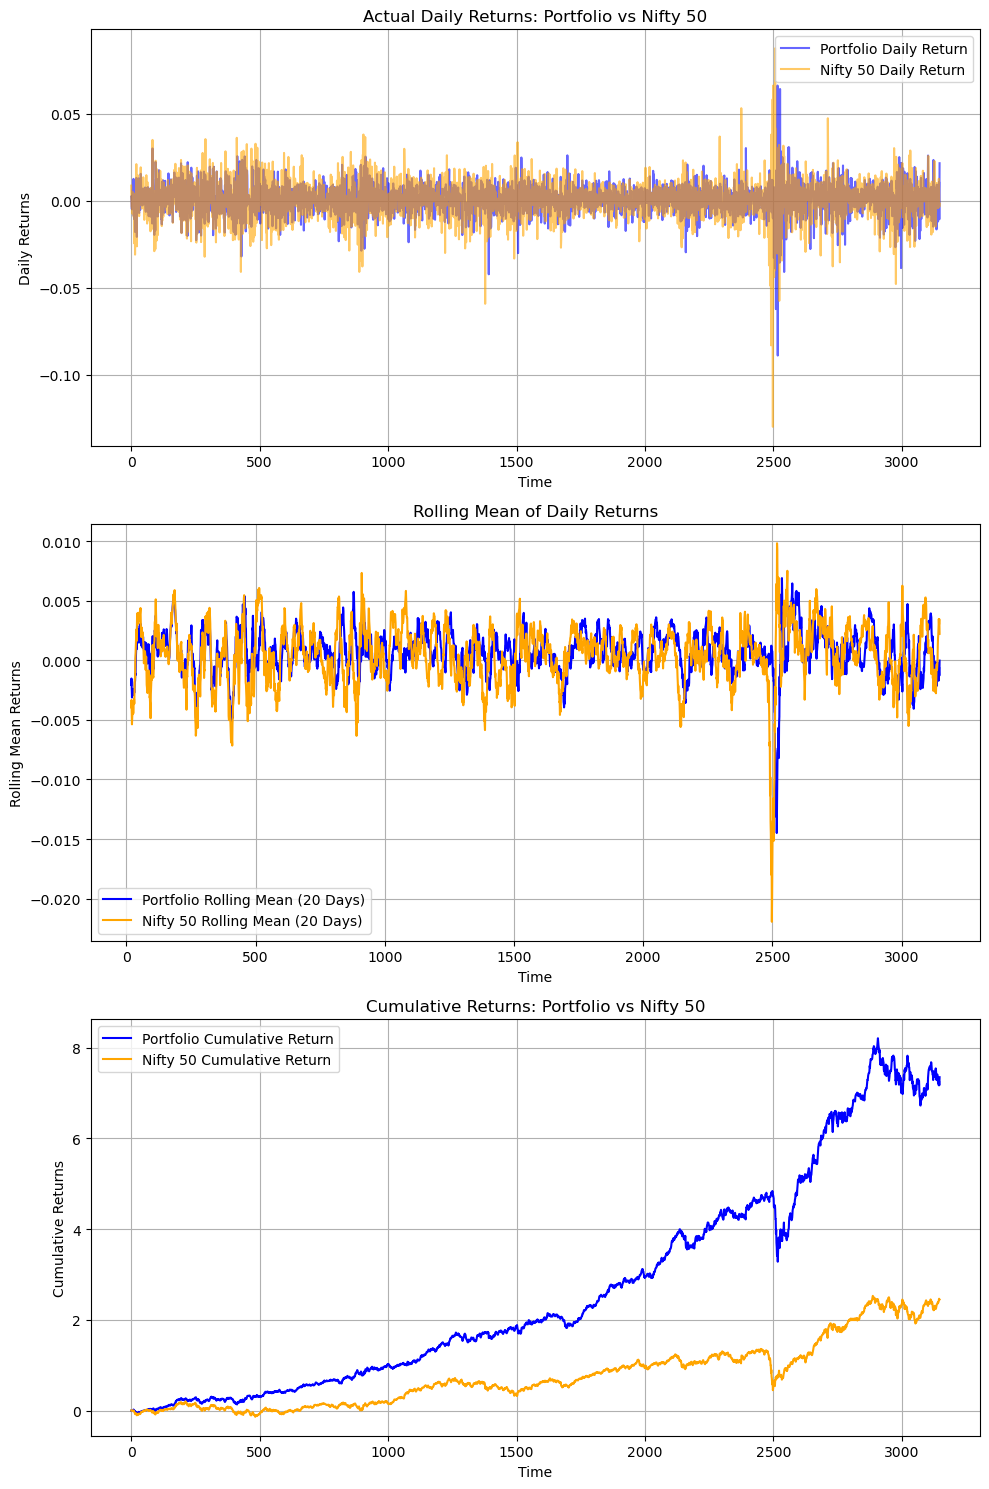

Annualized Sharpe Ratio for Portfolio: 0.0555


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def backtest_portfolio_with_benchmark(data_folder, portfolio_weights_file, nifty_data_file, feature_column='Close', transaction_cost=0.005, rolling_window=20, risk_free_rate=0.06):

    # Get list of stock CSV files from the data folder
    stock_data_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

    # Read portfolio weights, dropping the date column
    portfolio_weights = pd.read_csv(portfolio_weights_file, header=None)
    portfolio_weights = portfolio_weights.drop(columns=[0])  # Drop the date column

    # Initialize list for storing returns for each stock
    stock_returns_list = []
    
    for file in stock_data_files:
        # Read stock data and calculate returns (daily percentage change)
        stock_data = pd.read_csv(file)
        stock_returns = stock_data[feature_column].pct_change().dropna()
        stock_returns_list.append(stock_returns.values)
    
    # Convert stock returns into numpy array and trim to the same length
    min_length = min(len(r) for r in stock_returns_list)
    stock_returns = np.array([r[:min_length] for r in stock_returns_list]).T  # Shape: (time, num_stocks)
    
    # Ensure portfolio weights are aligned with the same length as the stock returns
    min_length = min(min_length, portfolio_weights.shape[0])  # Ensure both stock returns and weights have the same length
    portfolio_weights = portfolio_weights.values[:min_length, :]  # Trim portfolio weights to match length
    
    stock_returns = stock_returns[:min_length, :]  # Trim stock returns to match length

    # Calculate portfolio returns at each timestamp, with transaction cost penalty
    portfolio_returns = np.sum(stock_returns * portfolio_weights, axis=1)  # Element-wise multiplication and summation
    
    # Apply transaction cost penalty on rebalancing
    for i in range(1, len(portfolio_returns)):
        rebalance_cost = transaction_cost * np.sum(np.abs(portfolio_weights[i] - portfolio_weights[i-1]))
        portfolio_returns[i] -= rebalance_cost

    # Calculate cumulative returns over time for the portfolio
    portfolio_cumulative_returns = np.cumprod(1 + portfolio_returns) - 1  # Cumulative returns

    # Read Nifty 50 data and calculate its returns
    nifty_data = pd.read_csv(nifty_data_file)
    nifty_returns = nifty_data[feature_column].pct_change().dropna().values[:min_length]
    
    # Calculate cumulative returns for Nifty 50
    nifty_cumulative_returns = np.cumprod(1 + nifty_returns) - 1

    # Calculate rolling mean of portfolio returns (for visualization)
    rolling_portfolio_returns = pd.Series(portfolio_returns).rolling(window=rolling_window).mean()
    rolling_nifty_returns = pd.Series(nifty_returns).rolling(window=rolling_window).mean()
    
    # Calculate Sharpe Ratio (annualized) for the portfolio
    sharpe_ratio = (np.mean(portfolio_returns) - (risk_free_rate / 252)) / np.std(portfolio_returns)
    
    # Plot actual returns, rolling means, and cumulative returns for both portfolio and Nifty 50
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))
    
    # 1. Plot Actual Returns
    ax[0].plot(portfolio_returns, label="Portfolio Daily Return", color='blue', alpha=0.6)
    ax[0].plot(nifty_returns, label="Nifty 50 Daily Return", color='orange', alpha=0.6)
    ax[0].set_title("Actual Daily Returns: Portfolio vs Nifty 50")
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Daily Returns')
    ax[0].legend()
    ax[0].grid(True)
    
    # 2. Plot Rolling Mean of Returns
    ax[1].plot(rolling_portfolio_returns, label="Portfolio Rolling Mean ({} Days)".format(rolling_window), color='blue')
    ax[1].plot(rolling_nifty_returns, label="Nifty 50 Rolling Mean ({} Days)".format(rolling_window), color='orange')
    ax[1].set_title("Rolling Mean of Daily Returns")
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Rolling Mean Returns')
    ax[1].legend()
    ax[1].grid(True)
    
    # 3. Plot Cumulative Returns
    ax[2].plot(portfolio_cumulative_returns, label="Portfolio Cumulative Return", color='blue')
    ax[2].plot(nifty_cumulative_returns, label="Nifty 50 Cumulative Return", color='orange')
    ax[2].set_title("Cumulative Returns: Portfolio vs Nifty 50")
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('Cumulative Returns')
    ax[2].legend()
    ax[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Annualized Sharpe Ratio for Portfolio: {sharpe_ratio:.4f}")
    
    return portfolio_cumulative_returns, nifty_cumulative_returns

# File paths for your data
data_folder = r'C:\Users\Kartik\MTP-Work\data'
portfolio_weights_file = r'C:\Users\Kartik\MTP-Work\results\portfolio_weights.csv'
nifty_data_file = r'C:\Users\Kartik\MTP-Work\^NSEI.csv'

portfolio_cumulative_returns, nifty_cumulative_returns = backtest_portfolio_with_benchmark(
    data_folder, portfolio_weights_file, nifty_data_file, transaction_cost=0.005
)
